In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
import statsmodels.api as sm

df=pd.read_excel("C:\\Users\\Garimidi Siva Sree\\Downloads\\world_data_1960_onwards_yearly.xlsx")
df.info()
df.head




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 18 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Year                                                  63 non-null     int64  
 1   Consumer price index (2010 = 100)                     63 non-null     float64
 2   Crop production index (2014-2016 = 100)               63 non-null     float64
 3   GDP (constant LCU)                                    63 non-null     int64  
 4   GDP (current LCU)                                     63 non-null     int64  
 5   GDP growth (annual %)                                 63 non-null     float64
 6   GDP per capita (current US$)                          63 non-null     float64
 7   GDP per capita growth (annual %)                      63 non-null     float64
 8   Inflation, GDP deflator (annual %)                    63 non-n

<bound method NDFrame.head of     Year  Consumer price index (2010 = 100)  \
0   1960                           0.065886   
1   1961                           0.070023   
2   1962                           0.073710   
3   1963                           0.071724   
4   1964                           0.072338   
..   ...                                ...   
58  2018                         240.138364   
59  2019                         267.505547   
60  2020                         302.939394   
61  2021                         354.296242   
62  2022                         421.071120   

    Crop production index (2014-2016 = 100)  GDP (constant LCU)  \
0                                     19.31       9277979393400   
1                                     19.31       9295774139400   
2                                     20.41       9677179063400   
3                                     21.35      10507347377000   
4                                     21.86      11027512418000   
.. 

In [ ]:
df.isnull().sum()


Year                                                    0
Consumer price index (2010 = 100)                       0
Crop production index (2014-2016 = 100)                 0
GDP (constant LCU)                                      0
GDP (current LCU)                                       0
GDP growth (annual %)                                   0
GDP per capita (current US$)                            0
GDP per capita growth (annual %)                        0
Inflation, GDP deflator (annual %)                      0
Inflation, consumer prices (annual %)                   0
Livestock production index (2014-2016 = 100)            0
Official exchange rate (LCU per US$, period average)    0
Total reserves (includes gold, current US$)             0
Population, female                                      0
Population, male                                        0
Population ages 0-14 (% of total population)            0
Population ages 15-64 (% of total population)           0
Population age

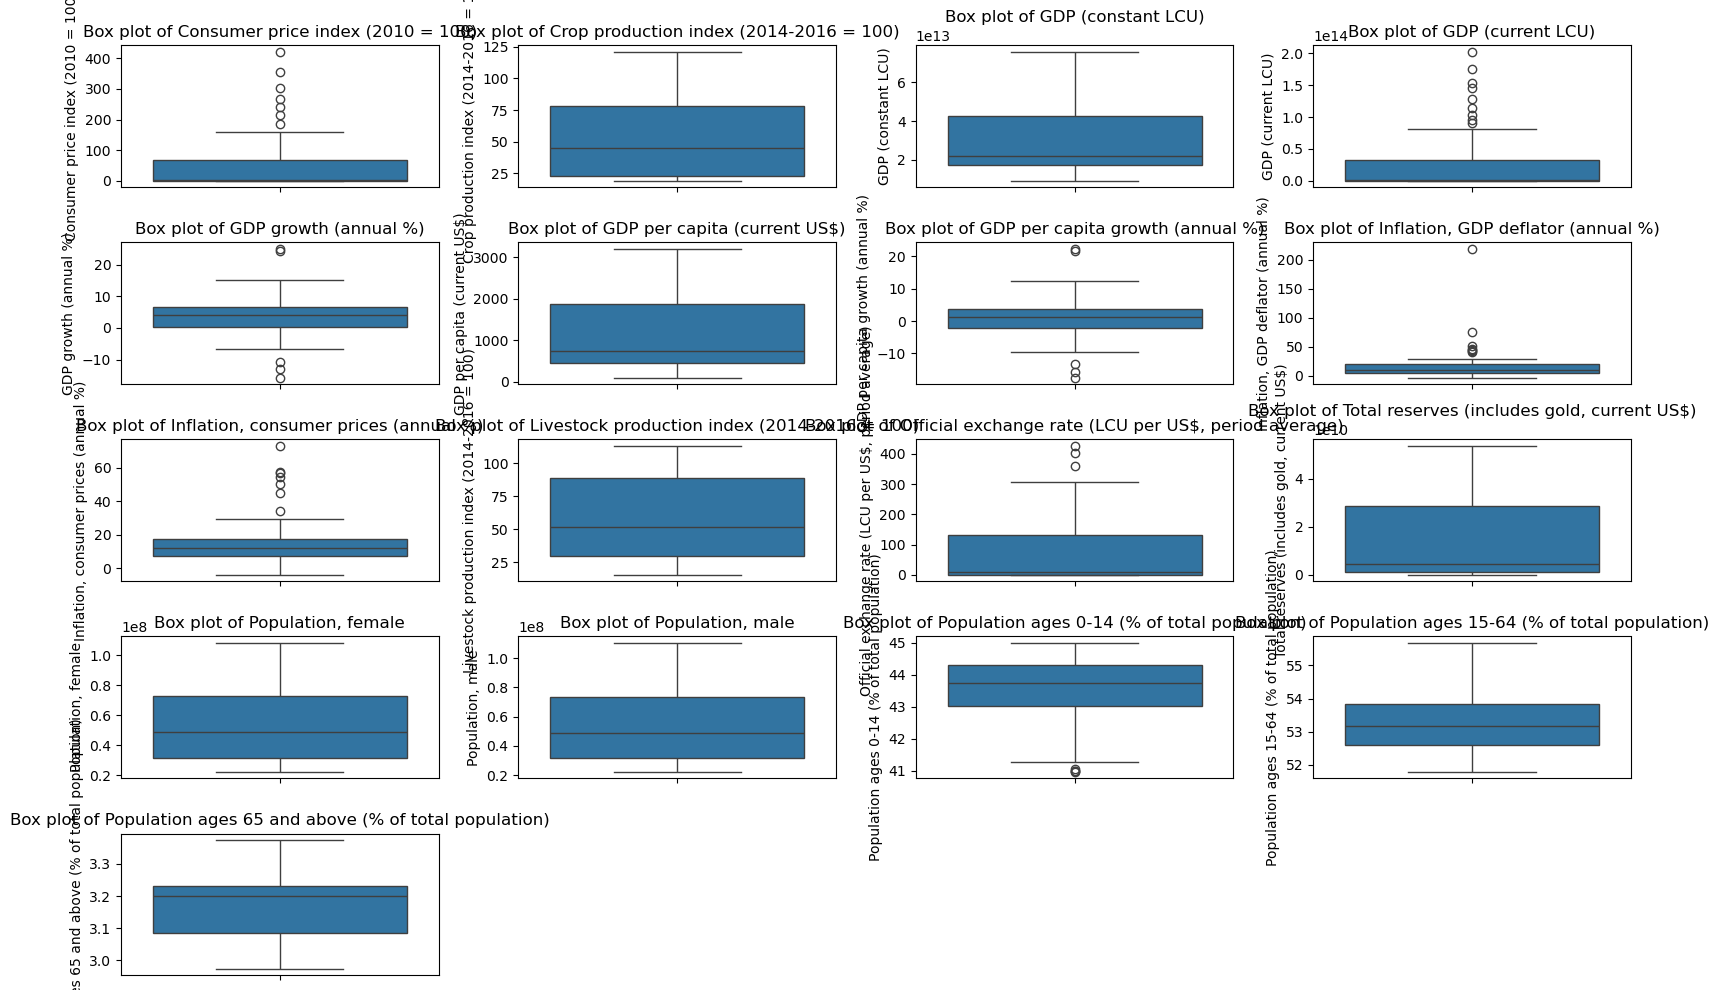

In [ ]:
def plot_boxplot(df,ft):
    df.boxplot(column = [ft])
    plt.grid(False)
    plt.show()

plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[1:], 1):
    plt.subplot(5, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
#Outlier detection using interquartilerange
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Year')
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound))
df.loc[outliers_mask.any(axis=1), numeric_cols] = np.nan
df_filled = df.ffill().bfill()
df_filled.to_excel("C:\\Users\\Garimidi Siva Sree\\Downloads\\new1960onwards.xlsx")

In [ ]:
df_filled.columns

Index(['Year', 'Consumer price index (2010 = 100)',
       'Crop production index (2014-2016 = 100)', 'GDP (constant LCU)',
       'GDP (current LCU)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'GDP per capita growth (annual %)',
       'Inflation, GDP deflator (annual %)',
       'Inflation, consumer prices (annual %)',
       'Livestock production index (2014-2016 = 100)',
       'Official exchange rate (LCU per US$, period average)',
       'Total reserves (includes gold, current US$)', 'Population, female',
       'Population, male', 'Population ages 0-14 (% of total population)',
       'Population ages 15-64 (% of total population)',
       'Population ages 65 and above (% of total population)'],
      dtype='object')

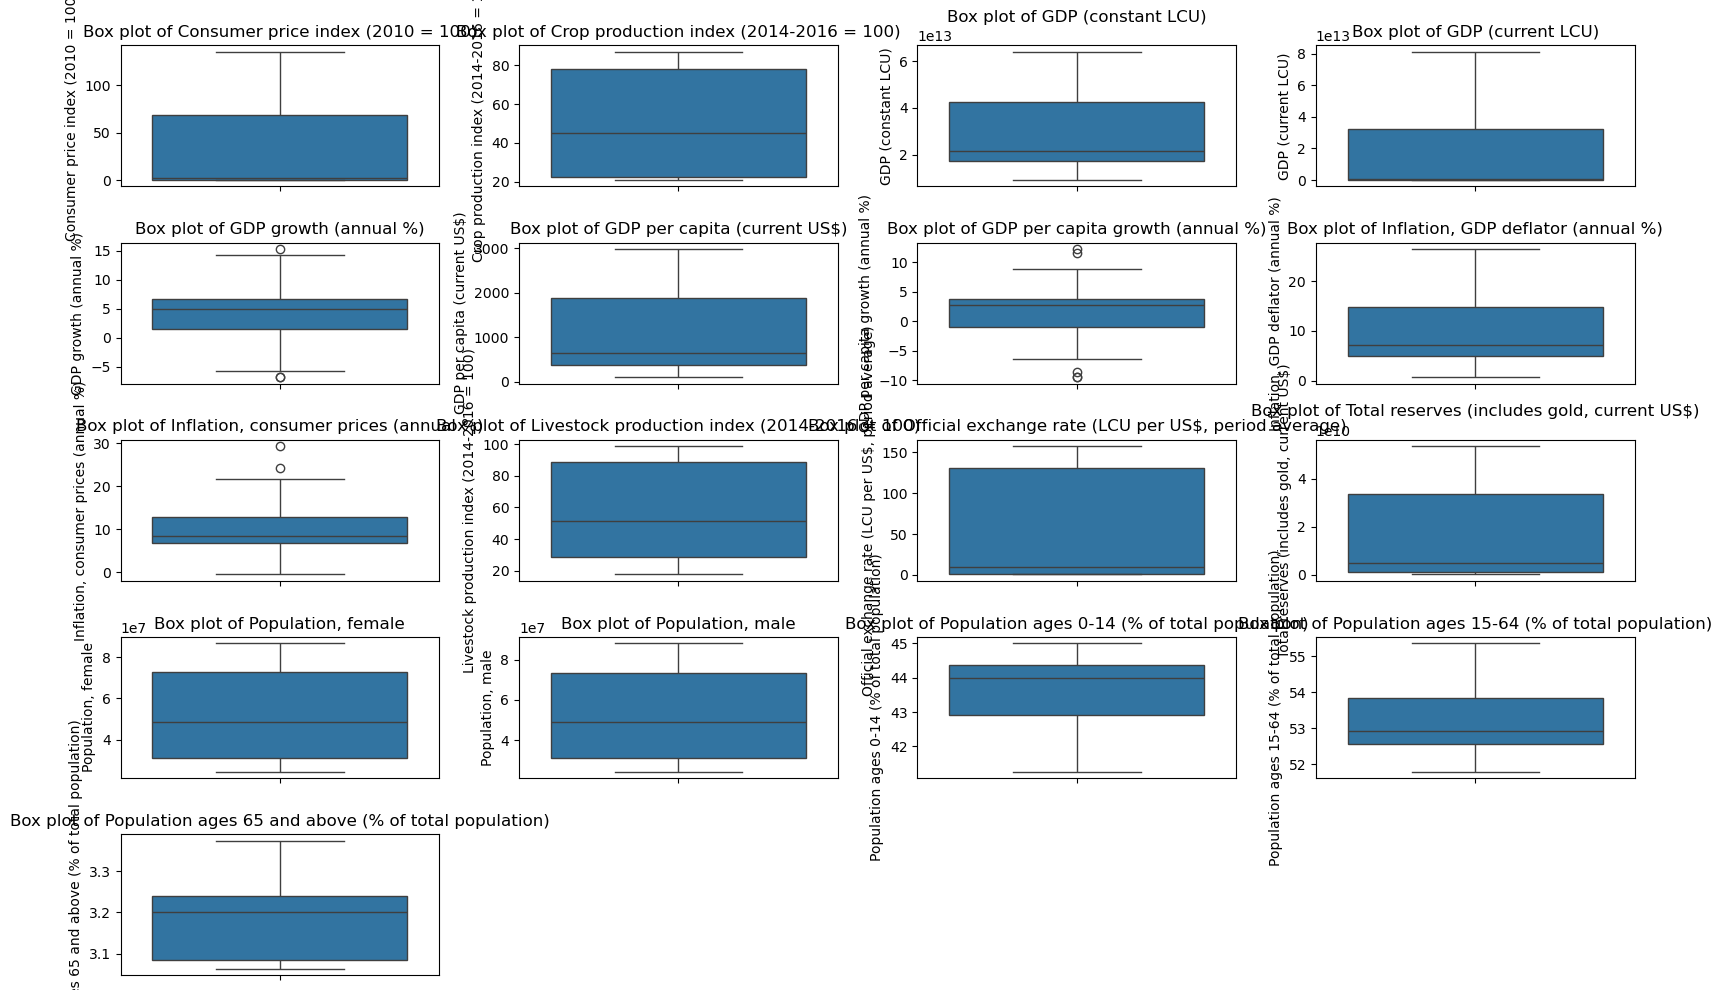

In [ ]:
def plot_boxplot(df_filled,ft):
    df_filled.boxplot(column = [ft])
    plt.grid(False)
    plt.show()

plt.figure(figsize=(16, 10))
for i, col in enumerate(df_filled.columns[1:], 1):
    plt.subplot(5, 4, i)
    sns.boxplot(y=df_filled[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Exclude the first column (assuming it's not needed for ADF test)
data_subset = df_filled.iloc[:, 1:]  # Select all rows, starting from the second column onward

# Iterate over each column (variable) in the subset
for col in data_subset.columns:
    result = adfuller(data_subset[col])

    # Print ADF test results for each variable
    print(f'ADF Test Results for "{col}"')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    print('\n')

ADF Test Results for "Consumer price index (2010 = 100)"
ADF Statistic: 0.4908401185270727
p-value: 0.9845920138931914
Critical Values:
1%: -3.542412746661615
5%: -2.910236235808284
10%: -2.5927445767266866


ADF Test Results for "Crop production index (2014-2016 = 100)"
ADF Statistic: -2.4907795340690573
p-value: 0.11773391259067256
Critical Values:
1%: -3.562878534649522
5%: -2.918973284023669
10%: -2.597393446745562


ADF Test Results for "GDP (constant LCU)"
ADF Statistic: -0.08799668735217776
p-value: 0.9506210630539316
Critical Values:
1%: -3.5443688564814813
5%: -2.9110731481481484
10%: -2.5931902777777776


ADF Test Results for "GDP (current LCU)"
ADF Statistic: -0.8368750451739301
p-value: 0.8080496631643881
Critical Values:
1%: -3.5443688564814813
5%: -2.9110731481481484
10%: -2.5931902777777776


ADF Test Results for "GDP growth (annual %)"
ADF Statistic: -2.1252650373746413
p-value: 0.2344774920237589
Critical Values:
1%: -3.5552728880540942
5%: -2.9157312396694217
10%: -2.

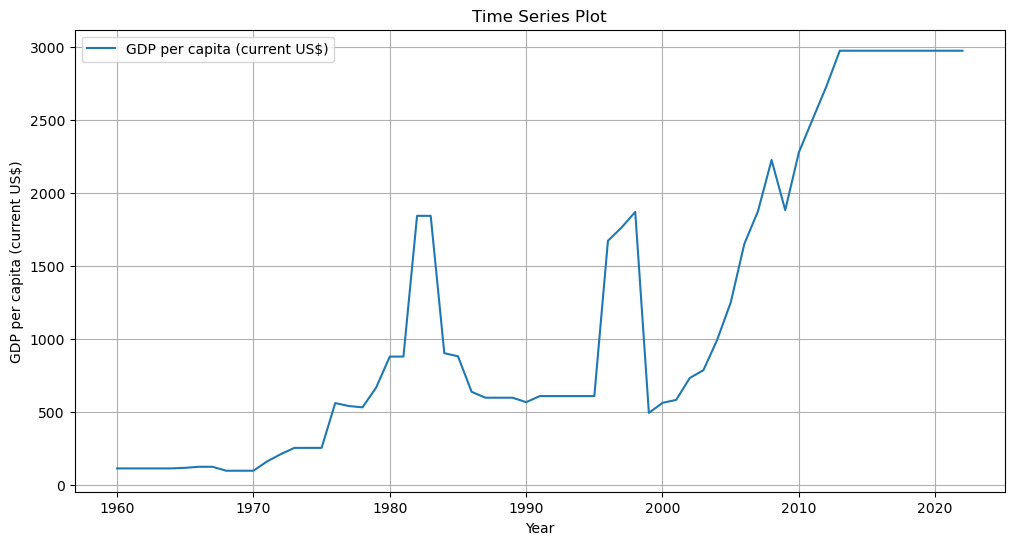

In [ ]:
#Time series analysis for GDP per capita (current US$)

df_filled['Year'] = pd.to_datetime(df_filled['Year'], format='%Y')

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(df_filled['Year'], df_filled['GDP per capita (current US$)'], label='GDP per capita (current US$)')
plt.xlabel('Year')
plt.ylabel('GDP per capita (current US$)')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()

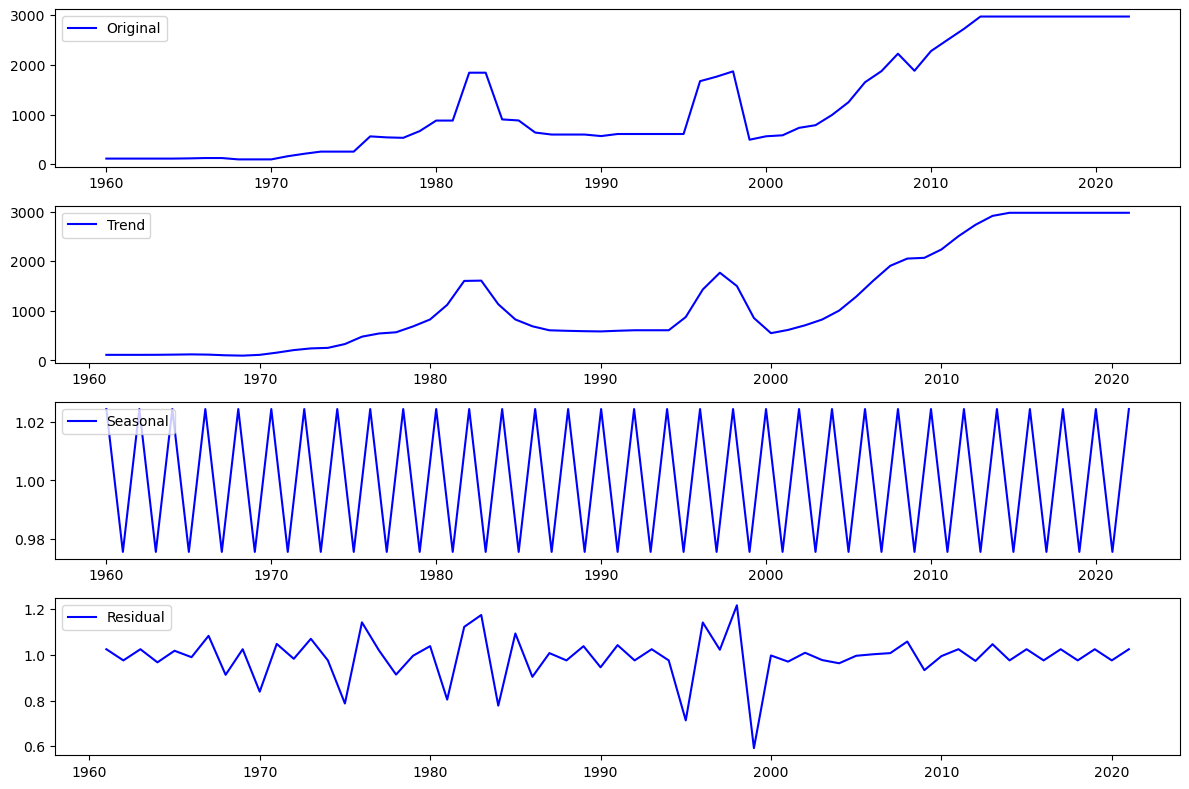

In [ ]:
df_filled['Year'] = pd.to_datetime(df_filled['Year'])

# Drop any NaN values if necessary
df_filled.dropna(inplace=True)

# Set 'Year' as the index if it's not already
df_filled.set_index('Year', inplace=True)

# Perform decomposition (assuming additive decomposition)
result = seasonal_decompose(df_filled['GDP per capita (current US$)'], model='multiplicative', period=2)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_filled['GDP per capita (current US$)'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

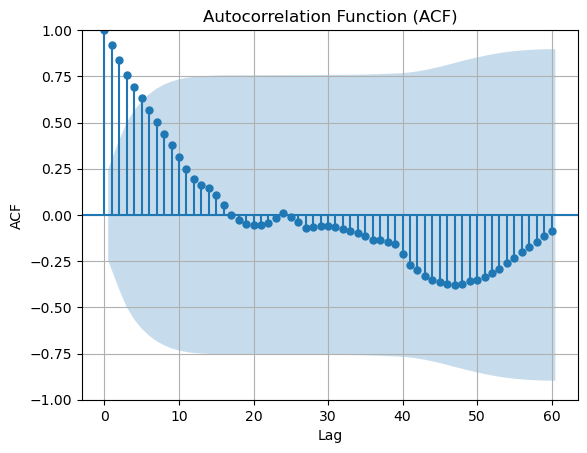

<Figure size 1000x400 with 0 Axes>

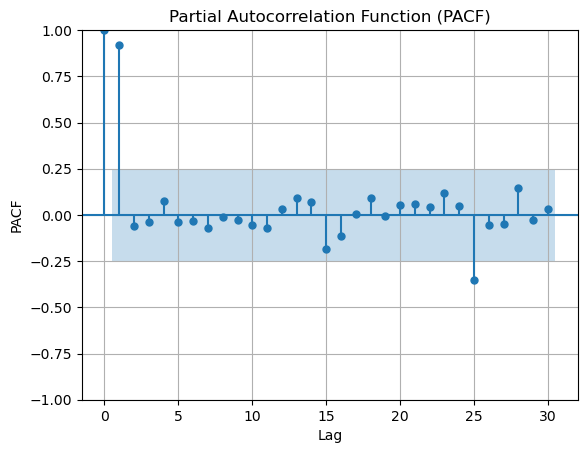

Ljung-Box test statistics:
lb_stat

Ljung-Box test p-values:
lb_pvalue


In [ ]:
#Testing for autocorrelation
# Plot autocorrelation function (ACF)
plt.figure(figsize=(10, 4))
plot_acf(df_filled['GDP per capita (current US$)'], lags=60, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()
# Plot partial autocorrelation function (PACF)
plt.figure(figsize=(10, 4))
plot_pacf(df_filled['GDP per capita (current US$)'], lags=30, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()
# Perform Ljung-Box test for autocorrelation
lb_test_stat, lb_p_value = acorr_ljungbox(df_filled['GDP per capita (current US$)'], lags=60)
print("Ljung-Box test statistics:")
print(lb_test_stat)
print("\nLjung-Box test p-values:")
print(lb_p_value)

In [ ]:
df_filled['trend_diff'] = df_filled['GDP per capita (current US$)'].diff(periods=1)
df_filled['seasonal_diff'] = df_filled['GDP per capita (current US$)'].diff(periods=12)
df_filled['seasonal_trend_diff'] = df_filled['GDP per capita (current US$)'].diff(periods=1).diff(periods=12)


In [ ]:
df_filled.index


DatetimeIndex(['1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
      

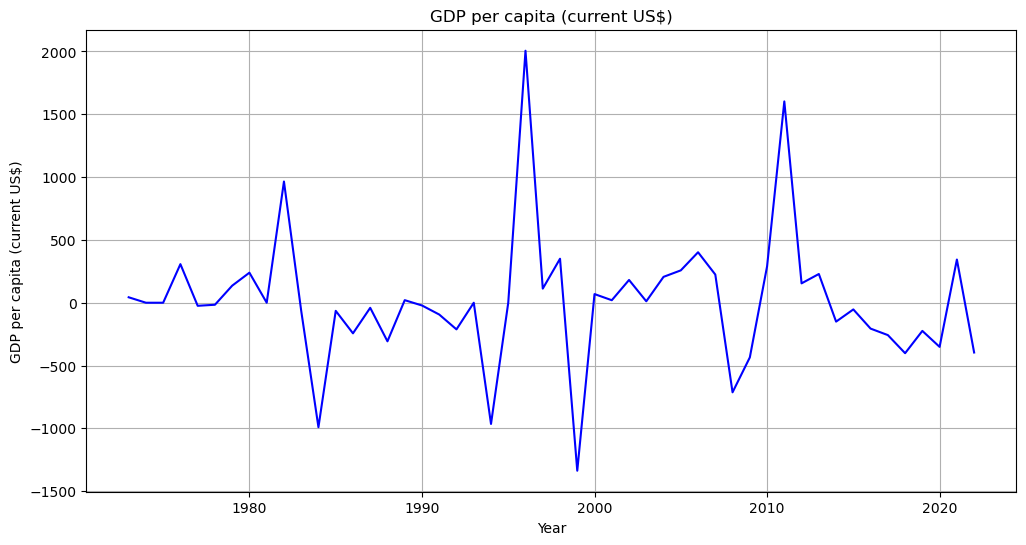

ADF Statistic: -2.9662617173407924
p-value: 0.038167524030080585
Critical Values:
	1%: -3.6155091011809297
	5%: -2.941262357486514
	10%: -2.6091995013850418
data is stationary


In [ ]:
# Plot the GDP data
plt.figure(figsize=(12, 6))
plt.plot(df_filled['seasonal_trend_diff'], color='blue')
plt.title('GDP per capita (current US$)')
plt.xlabel('Year')
plt.ylabel('GDP per capita (current US$)')
plt.grid(True)
plt.show()

# Perform Augmented Dickey-Fuller test
result = adfuller(df_filled['seasonal_trend_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Interpret the results
if result[1] < 0.05:
    print('data is stationary')
else:
    print('data is non-stationary')

In [ ]:
df_filled.columns

Index(['Consumer price index (2010 = 100)',
       'Crop production index (2014-2016 = 100)', 'GDP (constant LCU)',
       'GDP (current LCU)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'GDP per capita growth (annual %)',
       'Inflation, GDP deflator (annual %)',
       'Inflation, consumer prices (annual %)',
       'Livestock production index (2014-2016 = 100)',
       'Official exchange rate (LCU per US$, period average)',
       'Total reserves (includes gold, current US$)', 'Population, female',
       'Population, male', 'Population ages 0-14 (% of total population)',
       'Population ages 15-64 (% of total population)',
       'Population ages 65 and above (% of total population)', 'trend_diff',
       'seasonal_diff', 'seasonal_trend_diff'],
      dtype='object')

c:\Users\Garimidi Siva Sree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Garimidi Siva Sree\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Garimidi Siva Sree\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


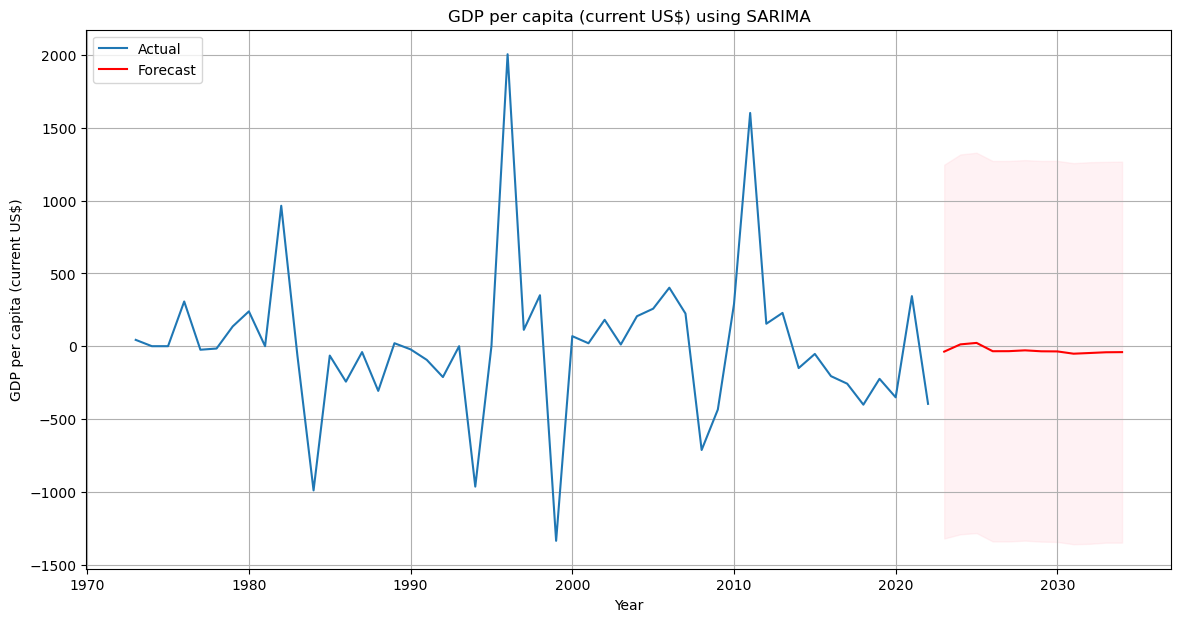

In [ ]:
# SARIMA model fitting and forecasting

model = SARIMAX(df_filled['seasonal_trend_diff'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()

# Forecasting
forecast_periods = 12  # Example: forecasting for 12 periods (months/years)
forecast = results.get_forecast(steps=forecast_periods)

# Confidence intervals for the forecast
forecast_ci = forecast.conf_int()

# Plotting the forecasted values
plt.figure(figsize=(14, 7))
plt.plot(df_filled.index, df_filled['seasonal_trend_diff'], label='Actual')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2)
plt.title('GDP per capita (current US$) using SARIMA')
plt.xlabel('Year')
plt.ylabel('GDP per capita (current US$)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
forecast_ci = forecast.conf_int()
print(forecast_ci)


            lower seasonal_trend_diff  upper seasonal_trend_diff
2023-01-01               -1321.199535                1246.593427
2024-01-01               -1292.372882                1317.193307
2025-01-01               -1284.030344                1329.096833
2026-01-01               -1341.392691                1272.275369
2027-01-01               -1341.135582                1272.731826
2028-01-01               -1335.715885                1278.497866
2029-01-01               -1342.678407                1272.535042
2030-01-01               -1344.974488                1273.057586
2031-01-01               -1360.574582                1257.371674
2032-01-01               -1357.733876                1264.110814
2033-01-01               -1349.737207                1266.190026
2034-01-01               -1349.541766                1267.912810


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
actual_values = df_filled['seasonal_trend_diff'].tail(forecast_periods)

# Extract predicted values
forecast_values = forecast.predicted_mean

# Calculate MAE
mae = mean_absolute_error(actual_values, forecast_values)

# Calculate MSE
mse = mean_squared_error(actual_values, forecast_values)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 342.2210320913427
Mean Squared Error (MSE): 281453.770645823
Root Mean Squared Error (RMSE): 530.5221679117876
